In [1]:
import os
import time
import sys
sys.path.append("../")
from data_utils.load_data import load_dataset
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.nn as nn



TEXT, vocab_size, word_embeddings, train_iter, valid_iter, test_iter = load_dataset()


Length of Text Vocabulary: 251639
Vector size of Text Vocabulary:  torch.Size([251639, 300])
Label Length: 2


In [2]:
# LSTM_Attention模型

class AttentionModel(torch.nn.Module):
	def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
		super(AttentionModel, self).__init__()
		
		"""
		Arguments
		---------
		batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
		output_size : 2 = (pos, neg)
		hidden_sie : Size of the hidden_state of the LSTM
		vocab_size : Size of the vocabulary containing unique words
		embedding_length : Embeddding dimension of GloVe word embeddings
		weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
		
		--------
		
		"""
		
		self.batch_size = batch_size
		self.output_size = output_size
		self.hidden_size = hidden_size
		self.vocab_size = vocab_size
		self.embedding_length = embedding_length
		
		self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
		self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
		self.lstm = nn.LSTM(embedding_length, hidden_size)
		self.label = nn.Linear(hidden_size, output_size)
		#self.attn_fc_layer = nn.Linear()
		
	def attention_net(self, lstm_output, final_state):

		""" 
		Now we will incorporate Attention mechanism in our LSTM model. In this new model, we will use attention to compute soft alignment score corresponding
		between each of the hidden_state and the last hidden_state of the LSTM. We will be using torch.bmm for the batch matrix multiplication.
		
		Arguments
		---------
		
		lstm_output : Final output of the LSTM which contains hidden layer outputs for each sequence.
		final_state : Final time-step hidden state (h_n) of the LSTM
		
		---------
		
		Returns : It performs attention mechanism by first computing weights for each of the sequence present in lstm_output and and then finally computing the
				  new hidden state.
				  
		Tensor Size :
					hidden.size() = (batch_size, hidden_size)
					attn_weights.size() = (batch_size, num_seq)
					soft_attn_weights.size() = (batch_size, num_seq)
					new_hidden_state.size() = (batch_size, hidden_size)
					  
		"""
		
		hidden = final_state.squeeze(0)
		attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
		soft_attn_weights = F.softmax(attn_weights, 1)
		new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
		
		return new_hidden_state
	
	def forward(self, input_sentences, batch_size=None):
	
		""" 
		Parameters
		----------
		input_sentence: input_sentence of shape = (batch_size, num_sequences)
		batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
		
		Returns
		-------
		Output of the linear layer containing logits for pos & neg class which receives its input as the new_hidden_state which is basically the output of the Attention network.
		final_output.shape = (batch_size, output_size)
		
		"""
		
		input = self.word_embeddings(input_sentences)
		input = input.permute(1, 0, 2)
		if batch_size is None:
			h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())
		else:
			h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
			
		output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0)) # final_hidden_state.size() = (1, batch_size, hidden_size) 
		output = output.permute(1, 0, 2) # output.size() = (batch_size, num_seq, hidden_size)
		
		attn_output = self.attention_net(output, final_hidden_state)
		logits = self.label(attn_output)
		
		return logits


In [3]:

learning_rate = 2e-5
batch_size = 32
output_size = 2
hidden_size = 256
embedding_length = 300

model = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)
loss_fn = F.cross_entropy

In [4]:

def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, train_iter, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            text = text.cuda()
            target = target.cuda()
        if (text.size()[0] != 32):# One of the batch returned by BucketIterator has length different than 32.
            continue
        optim.zero_grad()
        prediction = model(text)
        loss = loss_fn(prediction, target)
        num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
        acc = 100.0 * num_corrects/len(batch)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        
        # if steps % 250 == 0:
        #     print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()
        
    return total_epoch_loss/len(train_iter), total_epoch_acc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text = batch.text[0]
            if (text.size()[0] != 32):
                continue
            target = batch.label
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                text = text.cuda()
                target = target.cuda()
            prediction = model(text)
            loss = loss_fn(prediction, target)
            num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).sum()
            acc = 100.0 * num_corrects/len(batch)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/len(val_iter), total_epoch_acc/len(val_iter)
	

In [5]:
losses = []
accuracies = []
eval_accuracies = []
test_accuracies = []
temp_Acc = 0
total_epoch = 10
file_path='./models/best_lstm_attn.pth'
for epoch in range(total_epoch):
    train_loss, train_acc = train_model(model, train_iter, epoch)
    val_loss, val_acc = eval_model(model, valid_iter)
    test_loss, test_acc = eval_model(model, test_iter)
    losses.append(train_loss)
    accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    eval_accuracies.append(val_acc)
    # print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%,  Val. Acc: {val_acc:.2f}%')
    if test_acc>temp_Acc:
        temp_Acc = test_acc
        if os.path.exists(file_path):
            # 删除文件
            os.remove(file_path)
        torch.save(model.state_dict(),file_path )
import matplotlib.pyplot as plt




# 绘制损失-轮次图表
epochs = range(1, total_epoch+1)


/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torchtext/data/field.py:321: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train), lengths
/data3/wangzhiyong/miniconda3/envs/cv-homework/lib/python3.8/site-packages/torchtext/data/field.py:322: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return Variable(arr, volatile=not train)


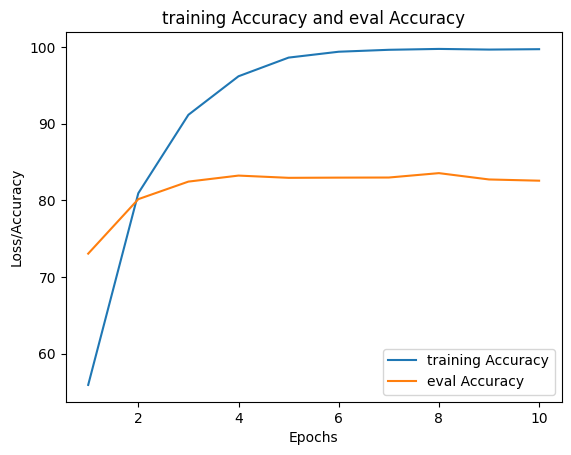

In [6]:
plt.plot(epochs, accuracies, label='training Accuracy')
plt.plot(epochs, eval_accuracies, label='eval Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('training Accuracy and eval Accuracy')
plt.legend()
plt.show()



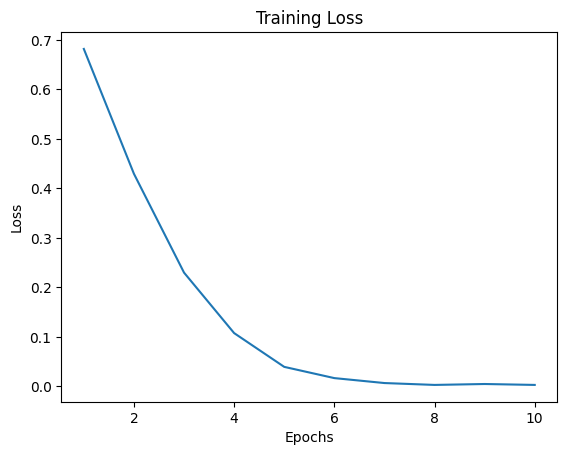

In [7]:
plt.plot(epochs, losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()



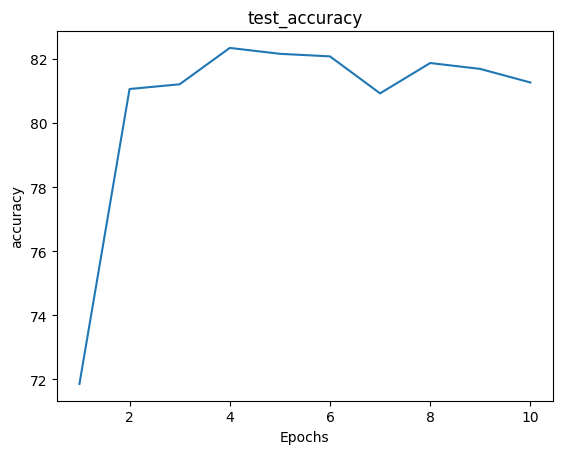

epoch:1,test accuracy:71.85501918158567
epoch:2,test accuracy:81.06218030690538
epoch:3,test accuracy:81.21003836317135
epoch:4,test accuracy:82.34494884910485
epoch:5,test accuracy:82.1611253196931
epoch:6,test accuracy:82.08120204603581
epoch:7,test accuracy:80.92631074168798
epoch:8,test accuracy:81.87340153452685
epoch:9,test accuracy:81.6895780051151
epoch:10,test accuracy:81.26598465473145


In [8]:
plt.plot(epochs, test_accuracies)
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('test_accuracy')
plt.show()
for e in epochs:
    print("epoch:{},test accuracy:{}".format(e,test_accuracies[e-1]))

In [9]:
testmodel = AttentionModel(batch_size, output_size, hidden_size, vocab_size, embedding_length, word_embeddings)

testmodel.load_state_dict(torch.load('models/best_lstm_attn.pth'))
test_sen1 = "This is one of the best creation of Nolan. I can say, it's his magnum opus. Loved the soundtrack and especially those creative dialogues."
test_sen1 = TEXT.preprocess(test_sen1)
test_sen1 = [[TEXT.vocab.stoi[x] for x in test_sen1]]
test_sen = np.asarray(test_sen1)
test_sen = torch.LongTensor(test_sen)
test_tensor = Variable(test_sen)
test_tensor = test_tensor.cuda()
model.eval()
output = model(test_tensor, 1)
out = F.softmax(output, 1)
if (torch.argmax(out[0]) == 1):
    print ("Sentiment: Positive")
else:
    print ("Sentiment: Negative")

Sentiment: Positive
